In [1]:
# wiomenmoxingfaileddezuoweijiaqiangxunlian GAN, shencheng shibiebuliaodehuibengdiao

In [2]:
import os

In [3]:
# when writing log, thought about what if we make it different so we flip the color
from PIL import Image
import os
import imageio.v2 as imageio
import numpy as np
import cv2

path = "/home/wg25r/fastdata/fullmoca/MoCA-Video-Train/"
rgb_dir = "./video_rgb_"
alpha_dir = "./video_alpha"

if os.path.exists(rgb_dir):
    os.system(f"rm -rf {rgb_dir}")
os.makedirs(rgb_dir)

if os.path.exists(alpha_dir):
    os.system(f"rm -rf {alpha_dir}")
os.makedirs(alpha_dir)

# for video in os.listdir(path):
def process_video(video):
    frame_dir = os.path.join(path, video, "Frame")
    gt_dir = os.path.join(path, video, "GT")
    if not (os.path.isdir(frame_dir) and os.path.isdir(gt_dir)):
        return
    frames = sorted(f for f in os.listdir(frame_dir) if f.lower().endswith(".jpg"))
    if len(frames) < 37:
        print(f"Video {video} has less than 37 frames, skipping...")
        return

    for idx in range(len(frames) // 37):
        seg_frames = frames[idx * 37:(idx + 1) * 37]

        rgb_out_path = os.path.join(rgb_dir, f"{video}_{idx:03d}.mp4")
        writer_rgb = imageio.get_writer(rgb_out_path, fps=24)
        for i, f in enumerate(seg_frames):
            img = imageio.imread(os.path.join(frame_dir, f))
            img_resized = Image.fromarray(img).resize((565, 320))
            writer_rgb.append_data(np.array(img_resized).astype(np.uint8))
        writer_rgb.close()

        alpha_out_path = os.path.join(alpha_dir, f"{video}_{idx:03d}.mp4")
        writer_alpha = imageio.get_writer(alpha_out_path, fps=24)
        for i, f in enumerate(seg_frames):
            alpha_name = os.path.splitext(f)[0] + '.png'
            mask = np.array(imageio.imread(os.path.join(gt_dir, alpha_name)))
            mask_resized = cv2.resize(mask, (565, 320), interpolation=cv2.INTER_NEAREST)
            img = np.array(imageio.imread(os.path.join(frame_dir, f)))
            img = cv2.resize(img, (565, 320), interpolation=cv2.INTER_NEAREST)
            foreground = np.where(mask_resized[:,:,None] > 0, img, 0).astype(int)
            foreground = np.clip(foreground, 0, 255).astype(np.uint8)
                        
            img_clipped = np.where(mask_resized[:,:,None] > 0, 255, 0)
                        
            writer_alpha.append_data(img_clipped.astype(np.uint8))
        writer_alpha.close()
    return img_clipped.astype(int), np.array(img_resized).astype(int)


In [4]:
videos = os.listdir(path)

a, b = process_video(videos[0]) 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (565, 320) to (576, 320) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (565, 320) to (576, 320) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


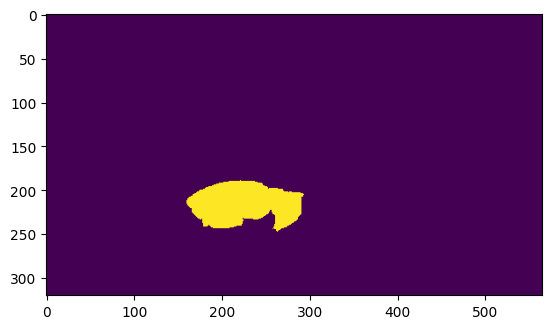

In [5]:
import matplotlib.pyplot as plt
plt.imshow(a)

In [6]:

# use a pool of 64 processes
from multiprocessing import Pool
pool = Pool(processes=64)
# map the function to the list of videos
pool.map(process_video, videos)
pool.close()
pool.join() 

Video flounder_3 has less than 37 frames, skipping...

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (565, 320) to (576, 320) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (565, 320) to (576, 320) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (565, 320) to (576, 320) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (565, 320) to (576, 320) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input ima

In [ ]:
from openai import OpenAI
from PIL import Image
import io
import base64
from pydantic import BaseModel
from typing import List, Optional

class Prompt(BaseModel):
    pos_prompt: str
    neg_prompt: str
    
def capture_image(imgs, filename):
    
    client = OpenAI()
    
    base64s = []
    for img in imgs:
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG")
        image_data = buffer.getvalue()
        base64_image = base64.b64encode(image_data).decode('utf-8')
        image_url = f"data:image/jpeg;base64,{base64_image}"
        base64s.append(image_url)
        
    response = client.beta.chat.completions.parse(
    model="gpt-4.1",
    messages=[
        {
        "role": "user",
        "content": [
            *[{
            "type": "image_url",
            "image_url": {
                "url": image_url
            }
            } for image_url in base64s],
            {
            "type": "text",
            "text": "Describe in 2-3 setence this image such that the prompt will be used to generate an video. Mention motion, the object might be hard to see. the filename is " + filename + ", filename might has other things than the animal. Do not mention filename just the animal name. The object might be hard to see (mention this) and blended into the envirement. Mention the animal is camflague and blend into the envirement for texture, color, and shape. Mention the animal's motion, but do not mention this makes it easy to spot. At the same time, provide a negative prompt, tell what the model should not generate, could be: clearly visible, standing out, easy to spot, obvious, distinct, high contrast, sharp outline, border, vibrant colors, unnatural colors, unnature bodies, blurry, low quality, pixelated, text, over exposure, etc. Do just just copy paste this, write it based on specific video. Both prompt should be description and not action requiring. Do not mention positive part in negative prompt and vice versa. Negative prompt should be description of what not to be in a positive way, e.g. 'ugly face', instead of 'do not generate ugly face'. Negative prompt should be information dense, not detialed, and just a list of words. " 
            }
        ]
        }, 
    ],
    response_format=Prompt,
    )
    return response.choices[0].message.content

import os
import cv2
videos = os.listdir("./video_rgb_")

def get_prompt(video):
    video_path = os.path.join("./video_rgb", video)
    
    cap = cv2.VideoCapture(video_path)
    frames = []
    # get first, middle, and last frame
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    middle_frame = total_frames // 2
    for i in [0, middle_frame, total_frames - 1]:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)
    cap.release()
    # Convert frames to PIL images
    imgs = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in frames]
    # Capture image and get prompt
    prompt = capture_image(imgs, video) 
    
    with open(os.path.join("./video_rgb", video.replace(".mp4", ".txt")), "w") as f:
        f.write(prompt)
    print(prompt)
    return prompt
videos = os.listdir("./video_rgb_")
print(len(videos))
# use a pool of 30 processes
from multiprocessing import Pool
if __name__ == "__main__":
    with Pool(30) as p:
        prompts = p.map(get_prompt, videos)
    print(prompts)

# get_prompt("crab_1_000.mp4")

1932


In [8]:
# import subprocess
# import os
# from PIL import Image
# import tqdm
# os.makedirs("single_frame", exist_ok=True)
# image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/Image"
# for img in tqdm.tqdm(os.listdir(image_path)):
#     img_path = os.path.join(image_path, img)
#     im = Image.open(img_path)
#     width, height = im.size
#     if width < 848 or height < 480:
#         scale_factor = max(848/width, 480/height)
#         new_width = int(width * scale_factor)
#         new_height = int(height * scale_factor)
#         vf_option = f"scale={new_width}:{new_height},crop=848:480"
#     else:
#         vf_option = "crop=848:480"
        
#     subprocess.run([
#         "ffmpeg",
#         "-loglevel", "error",
#         "-loop", "1",
#         "-i", img_path,
#         "-vf", vf_option,
#         "-c:v", "libx264",
#         "-t", "1",
#         "-pix_fmt", "yuv420p",
#         os.path.join("single_frame", img.replace(".jpg", ".mp4")),
#         "-y",
#     ])
#     # with open(os.path.join("single_frame", img.replace(".jpg", ".txt")), "w") as f:
#     #     f.write(img)


In [9]:
# import subprocess
# import os
# from PIL import Image
# import tqdm 
# os.makedirs("video_rgb_", exist_ok=True)
# image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/Image"
# def process_image(img):
#     img_path = os.path.join(image_path, img)
#     im = Image.open(img_path)
#     width, height = im.size
#     scale_factor = max(848/width, 480/height)
#     new_width = int(width * scale_factor)
#     new_height = int(height * scale_factor)
#     vf_option = f"scale={new_width}:{new_height},crop=848:480"

        
#     result = subprocess.run([
#         "ffmpeg",
#         "-loglevel", "error",
#         "-loop", "1",
#         "-i", img_path,
#         "-vf", vf_option,
#         "-c:v", "libx264",
#         "-t", "1",
#         "-pix_fmt", "yuv420p",
#         os.path.join("video_rgb_", img.replace(".jpg", ".mp4")),
#         "-y",
#     ], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
#     if result.returncode != 0:
#         print(result.stderr)
#         os.remove(os.path.join("video_rgb_", img.replace(".jpg", ".mp4")))

# images = os.listdir(image_path)
# images = [i for i in images if not "NonCAM" in i]

# # use a pool of 30 processes
# from multiprocessing import Pool
# if __name__ == "__main__":
#     with Pool(30) as p:
#         p.map(process_image, images)

In [10]:
# import subprocess
# import os
# from PIL import Image
# import tqdm 
# os.makedirs("video_alpha", exist_ok=True)
# image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/GT_Instance"
# def process_image(img):
#     img_path = os.path.join(image_path, img)
#     im = Image.open(img_path)
#     width, height = im.size
#     scale_factor = max(848/width, 480/height)
#     new_width = int(width * scale_factor)
#     new_height = int(height * scale_factor)
#     vf_option = f"scale={new_width}:{new_height},crop=848:480"

#     # Binarize the image
#     im = im.convert('L') # Ensure grayscale 
#     # Binarize: pixels > 0 become 255 (white), others 0 (black)
#     im = np.where(np.array(im) > 0, 255, 0).astype(np.uint8)
#     im_bin = Image.fromarray(im) # Convert back to PIL Image
    
#     # Use tempfile for the binarized image
#     temp_f = None # Initialize to None
#     try:
#         # Create a temporary file to save the binarized image
#         with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_f:
#             im_bin.save(temp_f.name)
#             temp_img_path = temp_f.name # Get the path to the temporary file

#         # Modify the ffmpeg command to use the temporary binarized file and include vf_option
#         result = subprocess.run([
#             "ffmpeg",
#             "-loglevel", "error",
#             "-loop", "1",
#             "-i", temp_img_path, # Use the temporary binarized image as input
#             "-vf", vf_option,    # Apply scaling/cropping
#             "-c:v", "libx264",
#             "-t", "1",
#             "-pix_fmt", "yuv420p",
#             os.path.join("video_alpha", os.path.basename(img_path).replace(".png", ".mp4")), # Use original base name for output
#             "-y",
#         ], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

#         if result.returncode != 0:
#             print(f"FFmpeg error for {img}: {result.stderr}")
#             output_path = os.path.join("video_alpha", os.path.basename(img_path).replace(".png", ".mp4"))
#             if os.path.exists(output_path):
#                  os.remove(output_path) # Clean up potentially corrupted output

#     finally:
#         # Clean up the temporary file if it was created
#         if temp_f and os.path.exists(temp_f.name):
#             os.remove(temp_f.name)

#     # The original ffmpeg call is replaced by the one inside the try block
#     return # Exit function here as processing is done

# # The rest of the original ffmpeg call below this selection is now redundant
# # because it's handled within the try block above.
# # We add a 'return' above to prevent executing the code below the placeholder.

# images = os.listdir(image_path)
# # use a pool of 30 processes
# images = [i for i in images if not "NonCAM" in i]
# from multiprocessing import Pool
# import tempfile
# if __name__ == "__main__":
#     with Pool(30) as p:
#         p.map(process_image, images)

In [11]:
# path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/GT_Instance/"
# file = path + os.listdir(path)[0]
# im = Image.open(file).convert('L')
# im = np.where(np.array(im) > 0, 255, 0).astype(np.uint8)
# im_bin = Image.fromarray(im)
# im_bin

In [12]:

# import subprocess
# import os
# from PIL import Image
# import tqdm 
# os.makedirs("video_rgb_", exist_ok=True)
# image_path = "/home/wg25r/fastdata/COD/COD10K-v3/Train/Image"
# def process_image(img):
#     img_path = os.path.join(image_path, img)
#     im = Image.open(img_path)
    